# Convolutional Variational Autoencoder (CNN-VAE)

In [6]:
import sys
import os
from os.path import join
parent_dir = os.path.abspath(join(os.getcwd(), os.pardir))
app_dir = join(parent_dir, "app")
if app_dir not in sys.path:
      sys.path.append(app_dir)

from pathlib import Path
import torch as pt
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from CNN_VAE import ConvDecoder, ConvEncoder, Autoencoder
from utils.training_loop import train_cnn_vae
import utils.config as config
from sklearn import metrics
import matplotlib.pyplot as plt

# use GPU if possible
device = pt.device("cuda:0") if pt.cuda.is_available() else pt.device("cpu")

DATA_PATH = Path(os.path.abspath('')).parent / "data"
OUTPUT_PATH = Path(os.path.abspath('')).parent / "output" / "VAE"

#### Initialize Autoencoder and additional parameters

In [2]:
# initialize CNN-VAE classes
encoder = ConvEncoder(
    in_size=config.target_resolution,
    n_channels=config.input_channels,
    n_latent=config.latent_size,
    batchnorm=True,
    variational=True
)

decoder = ConvDecoder(
    in_size=config.target_resolution,
    n_channels=config.output_channels,
    n_latent=config.latent_size,
    batchnorm=True,
    squash_output=True
)

autoencoder = Autoencoder(encoder, decoder)
autoencoder.to(device)

Autoencoder(
  (_encoder): ConvEncoder(
    (_layers): ModuleList(
      (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
      (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
      (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (_latent_mean): Linear(in_features=65536, out_features=256, bias=True)
    (_latent_log_var): Linear(in_features=65536, out_features=256, bias=True)
  )
  (_decoder): ConvDecoder(
    (_layers): ModuleList(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (1): BatchNorm2d(256, e

#### Load datasets and initialize dataloaders

In [3]:
train_dataset = pt.load(join(DATA_PATH, "train_dataset.pt"))
val_dataset = pt.load(join(DATA_PATH, "val_dataset.pt"))
test_dataset = pt.load(join(DATA_PATH, "test_dataset.pt"))

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True)

#### Initialize training metrics and objects

In [4]:
# optimizer
optimizer = pt.optim.Adam(autoencoder.parameters(), lr=config.learning_rate)

test_result = train_cnn_vae(
    model=autoencoder,
    loss_func=nn.MSELoss(),
    train_loader=train_loader,
    epochs=config.epochs,
    optimizer=optimizer
)

 Epoch    9/9 - Training loss: 1.512852e-01

#### Plot loss over epochs

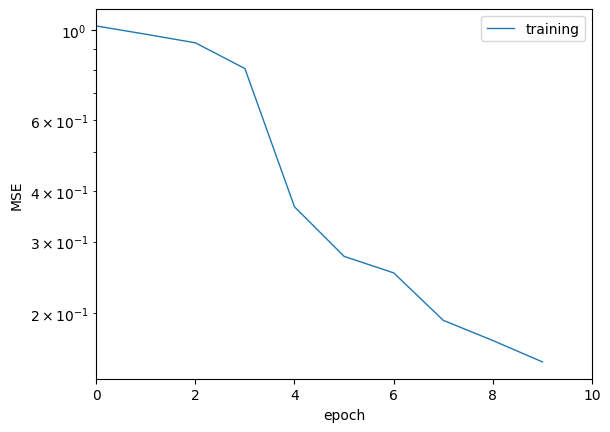

In [7]:
plt.plot(test_result["epoch"], test_result["train_loss"], lw=1, label="training")
# plt.plot(test_result["epoch"], test_result["val_loss"], lw=1, label="validation")
# plt.plot(test_result["epoch"], test_result["test_loss"], lw=1, label="testing")
plt.yscale("log")
plt.xlim(0, config.epochs)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()